# Vision Transformer

Taking the idea from NLP, [An Image is Worth 16x16 Words](https://arxiv.org/abs/2010.11929) applies transformer to computer vision tasks. 


Multiple layers of multi-head self-attention (MSA) and multi-layer perceptron (basically a feed-forward network like above) is applied on $z$. Let `L` represents how many layers of self-attention to apply. 

$$
z_l^{\prime} = \text{MSA}\,(\text{LayerNorm}\,(z_{l-1})) + z_{l-1} \;\; l = 1, ..., L
$$

$$
z_l = \text{MLP}\,(\text{LayerNorm}\,(z_l^{\prime})) + z_l^{\prime} \;\; l = 1, ..., L
$$

The final output will be coming from the last layer of the attention block.

$$
y = \text{LayerNorm}\,(z^0_L)
$$

![Vision Transformer](assets/vision-transformer.png)

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

## Reshape Inputs

The model expects `(N, 3, 224, 224)` input.

transformed shape torch.Size([1, 3, 224, 224])


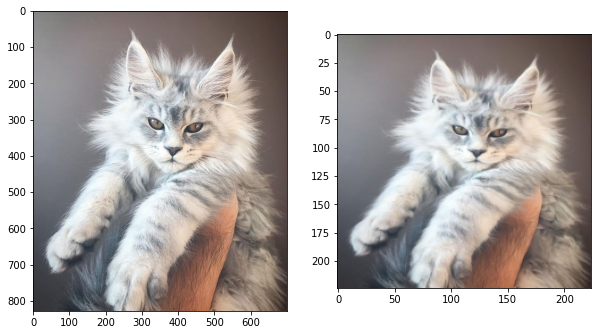

In [24]:
transform = Compose([
    Resize((224, 224)),
    ToTensor()
])

fig, axs = plt.subplots(1, 2, figsize=(10, 20))

img = Image.open('assets/mainecoon.jpg')
axs[0].imshow(img)

x = transform(img)
axs[1].imshow(x.permute(1, 2, 0))

x = x.unsqueeze(0)
print(f"transformed shape {x.shape}")

Using `einops`, the original picture is broken down `14*14 = 196` patches while each patch is flatten to `16*16*3 = 768` dimensions vector.

In [26]:
patch_size = 16
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
print(f"patch shape {patches.shape}")

patch shape torch.Size([1, 196, 768])


## Patching

The standard transformer receives a 1D sequence of token embeddings, vision transformer receives a sequence of flattended 2D patches

$$
x_p \in \mathbb{R}^{N \times (P^2 \cdot C)}
$$

The original image $x$ has shape $\mathbb{R}^{H \times W \times C}$ which is height times width times channels. The 2D patch has square patches of shape `(P, P)` where P is the number of pixels in each side of the patch. $P^2$ represents the total number of pixels in each patch and $C$ is the color channel which is 3 or 4 in most cases. `N` represents the number of patches used in the image. Essentially this is reshaping the image into words-like representation.

The pixel values $x_p$ will be linearly projected into an embedding space with dimension `D`. Position embeddings are also added to the patch embeddings to retain positional information.

$$
E \in \mathbb{R}^{(P^2 \cdot C) \times D}
$$

$$
E_{pos} \in  \mathbb{R}^{(N+1) \times D}
$$

$$
z_0 = E + E_{pos}
$$

**Hybrid Architecture**

> As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et 
  al., 1989). In this hybrid model, the patch embedding projection E (Eq. 1) is applied to patches extracted from   a CNN feature map. As a special case, the patches can have spatial size 1x1, which means that the input sequence 
  is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer 
  dimension. The classification input embedding and position embeddings are added as described above.

In [36]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        super().__init__()
        self.patch_size = patch_size
        self.projection = nn.Sequential(
            # Project the patches linearly by running convolution to each patch.
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            # Break down the image into s1 x s2 patches and flatten them
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size)**2 + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        batch_size, _, _, _ = x.shape
        
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=batch_size)
        
        # Prepend the class token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        
        # Add position embedding
        x += self.positions

        return x


PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

## Vision Transformer Encoder

<img src='assets/vision-transformer-encoder.png' width=200>

### Multi-Head Attention

In [39]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 512, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        
        # Queries, keys, and values are just embeddings
        self.queries = nn.Linear(emb_size, emb_size)
        self.keys = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # Split queries, keys, and values by number of heads
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        
        # Sum over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        # Scaling factor for softmax
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling 
        att = self.att_drop(att)

        # Sum over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

For better parallelism, it's better to fuse all queries, keys, and values into one giant matrix.

In [40]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # Fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # Split queries, keys, and values by number of heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]

        # Sum over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        # Scaling factor for softmax
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)

        # Sum over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

In [41]:
patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 197, 768])

### Residual Connection

There is a residual operation right after the multi-head attention. We can just group the layer norm and multi-head attention into one function `fn`, and write a wrapper for the residual connection.

![Vision Transformer Residual Connection](assets/vision-transformer-residual.png)

In [45]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

### Feedforward MLP

The final ingredient is the MLP block above the multi-head attention.

In [46]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

### Encoder

Combining everything above, the final transformer encoder is the following.

In [51]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):

        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            ))
        )


class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])



In [53]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoder(depth=10)(patches_embedded).shape

torch.Size([1, 197, 768])

## ViT Full Architecture

The output from encoder is a rich latent representation of the source image. We can use the output to perform classification task as the paper suggests. 

> Both during pre-training and fine-tuning, a classification head is attached to $z^0_L$. The classification head 
  is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning 
  time.

In [54]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

In [55]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [56]:
summary(ViT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6          [-1, 8, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
MultiHeadAttention-8             [-1, 197, 768]               0
           Dropout-9             [-1, 197, 768]               0
      ResidualAdd-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear-12            [-1, 197, 3072]       2,362,368
             GELU-13            [-1, 197, 3072]               0
          Dropout-14            [-1, 19